# Deep Neural Network for Fraud Detection: Application

## Packages

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
#from dnn_app_utils_v3 import *
import csv
import pandas as pd
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
import keras
print(tf.__version__)
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
import pandas as pd
import random
from sklearn.model_selection import train_test_split
%load_ext autoreload
%autoreload 2

np.random.seed(1)

Using TensorFlow backend.


2.0.0


## Dataset

The data for credit card fraud detection is from: 
https://www.kaggle.com/mlg-ulb/creditcardfraud

In [2]:
d = pd.read_csv("./creditcardfraud/creditcard.csv")


In [3]:
train, test = train_test_split(d, test_size=0.2)
train_y = train.pop('Class')
train_x_orig = train
test_y = test.pop('Class')
test_x_orig = test
#train_x_orig = train[:,0:30] .values
#train_y = train['Class'].values
#test_x_orig = test[:,0:30]
#test_y = test[:,-1]

In [4]:
# Explore your dataset
m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))

print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 227845
Number of testing examples: 56962
train_x_orig shape: (227845, 30)
train_y shape: (227845,)
test_x_orig shape: (56962, 30)
test_y shape: (56962,)


In [5]:
# Explore further
train_x_orig.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
13367,23610.0,1.387525,-0.547811,0.076422,-0.739334,-0.519887,-0.026007,-0.694673,-0.052100,0.378187,...,-0.469630,-0.658299,-1.307286,-0.013221,-0.912415,0.163178,0.920997,-0.096560,-0.014846,31.35
31788,36516.0,1.021179,-0.194114,1.207791,1.738369,-0.659824,0.631864,-0.434168,0.227422,1.116400,...,-0.090960,-0.386993,-0.664598,0.047173,0.106897,0.443932,-0.515898,0.091188,0.035959,41.29
84796,60465.0,-1.134453,0.636843,2.457241,1.317848,0.605755,0.143546,0.242076,0.371466,-1.315582,...,-0.040412,0.328508,0.683118,-0.114294,0.203942,0.035426,-0.090987,0.057247,0.102961,23.27
6243,7309.0,-0.851343,0.062000,1.406917,-1.669375,0.462639,-0.150804,0.403887,0.200460,1.968672,...,-0.301203,-0.400262,-1.096108,0.023423,-0.842077,-0.301144,0.932506,-0.088128,0.076487,45.00
162432,115111.0,-0.040314,0.545458,0.831788,-0.515723,0.128584,-0.112466,0.027800,0.222503,0.639397,...,-0.120943,0.102439,0.351638,0.180840,0.572238,-1.486248,0.147366,0.253324,0.291266,9.84


In [6]:
# Reshape the training and test examples
train_x_flatten = train_x_orig.values.reshape(train_x_orig.shape[0], -1)
train_x_flatten

array([[ 2.36100000e+04,  1.38752494e+00, -5.47811116e-01, ...,
        -9.65601597e-02, -1.48461215e-02,  3.13500000e+01],
       [ 3.65160000e+04,  1.02117876e+00, -1.94113665e-01, ...,
         9.11875105e-02,  3.59594694e-02,  4.12900000e+01],
       [ 6.04650000e+04, -1.13445277e+00,  6.36842930e-01, ...,
         5.72469651e-02,  1.02960891e-01,  2.32700000e+01],
       ...,
       [ 5.50950000e+04, -1.14996324e+00,  1.69646167e+00, ...,
        -1.62046536e-01,  3.11927890e-02,  7.58000000e+00],
       [ 1.62728000e+05,  1.75455368e+00, -6.99398285e-01, ...,
        -5.85290816e-03, -1.96220758e-02,  9.48000000e+01],
       [ 7.85760000e+04, -7.07635006e-01,  4.93302266e-01, ...,
        -3.85588609e-01, -2.05588932e-01,  5.78000000e+01]])

In [7]:
# Reshape the training and test examples
train_x_flatten = train_x_orig.values.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.values.reshape(test_x_orig.shape[0], -1).T
train_y_flatten = train_y.values.reshape(train_y.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_y_flatten = test_y.values.reshape(test_y.shape[0], -1).T

#train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
#test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
#train_y_flatten = train_y.reshape(train_y.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
#test_y_flatten = test_y.reshape(test_y.shape[0], -1).T

X_train = train_x_flatten
Y_train = train_y_flatten
X_test = test_x_flatten
Y_test = test_y_flatten

Y_train = convert_to_one_hot(Y_train.astype(int), 2)
Y_test = convert_to_one_hot(Y_test.astype(int), 2)

print ("number of training examples = " + str(X_train.shape))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = (30, 227845)
number of test examples = 56962
X_train shape: (30, 227845)
Y_train shape: (2, 227845)
X_test shape: (30, 56962)
Y_test shape: (2, 56962)


## Tensorflow Neural Network

In [11]:
def create_placeholders(n_x, n_y):
    
    """
    Creates the placeholders for the tensorflow session.

    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)

    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"

    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.compat.v1.placeholder(tf.float32, [n_x,None])
    Y = tf.compat.v1.placeholder(tf.float32, [n_y,None])

    return X, Y

In [12]:
X, Y = create_placeholders(30, 2)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(30, None), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(2, None), dtype=float32)


In [13]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]

    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """

    tf.compat.v1.set_random_seed(1)

    W1 = tf.compat.v1.get_variable("W1", [25,30], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    b1 = tf.compat.v1.get_variable("b1", [25,1], initializer = tf.compat.v1.zeros_initializer())
    W2 = tf.compat.v1.get_variable("W2", [12,25], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    b2 = tf.compat.v1.get_variable("b2", [12,1], initializer = tf.compat.v1.zeros_initializer())
    W3 = tf.compat.v1.get_variable("W3", [2,12], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    b3 = tf.compat.v1.get_variable("b3", [2,1], initializer = tf.compat.v1.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}

    return parameters

In [14]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W0216 16:22:37.674734 139713218598720 deprecation.py:506] From /home/anjana/tensorflow/venv/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


W1 = <tf.Variable 'W1:0' shape=(25, 30) dtype=float32>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32>


In [15]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    #                                                                   # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                                     # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                                 # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                    # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                                 # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                    # Z3 = np.dot(W3,Z2) + b3

    return Z3

In [16]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as sess:
    X, Y = create_placeholders(30, 2)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(2, None), dtype=float32)


In [17]:
def compute_cost(Z3, Y):
    """
    Computes the cost

    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    """

    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(a=Z3)
    labels = tf.transpose(a=Y)
    cost = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))

    return cost

In [18]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as sess:
    X, Y = create_placeholders(30, 2)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [19]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.

    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.compat.v1.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost

    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()

    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)

    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)

    # Backpropagation: Define the tensorflow optimizer. Using AdamOptimizer.
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    # Initialize all the variables
    init = tf.compat.v1.global_variables_initializer()

    # Saver for model
    saver = tf.compat.v1.train.Saver()

    # Start the session to compute the tensorflow graph
    with tf.compat.v1.Session() as sess:

        # Run the initialization
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch

                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost",
                # the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer,cost], feed_dict = {X:minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(input=Z3), tf.argmax(input=Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

        saver.save(sess, './my_test_model')

        return parameters


Cost after epoch 0: 174.062966
Cost after epoch 100: 0.114000
Cost after epoch 200: 0.004611
Cost after epoch 300: 0.005087
Cost after epoch 400: 0.004167
Cost after epoch 500: 0.004150
Cost after epoch 600: 0.003919
Cost after epoch 700: 0.004421
Cost after epoch 800: 0.004086
Cost after epoch 900: 0.004239
Cost after epoch 1000: 0.004527
Cost after epoch 1100: 0.005186
Cost after epoch 1200: 0.005092
Cost after epoch 1300: 0.004645
Cost after epoch 1400: 0.005285


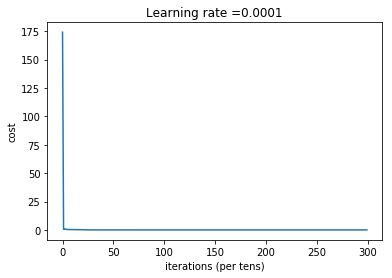

Parameters have been trained!
Train Accuracy: 0.9988984
Test Accuracy: 0.99885887


In [20]:
parameters = model(X_train, Y_train, X_test, Y_test)

In [45]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(value=parameters["W1"])
    b1 = tf.convert_to_tensor(value=parameters["b1"])
    W2 = tf.convert_to_tensor(value=parameters["W2"])
    b2 = tf.convert_to_tensor(value=parameters["b2"])
    W3 = tf.convert_to_tensor(value=parameters["W3"])
    b3 = tf.convert_to_tensor(value=parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    #x = tf.compat.v1.placeholder("float", [12288, 30])
    x = tf.compat.v1.placeholder("float", [30, 56962])
    
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(input=z3)
    
    sess = tf.compat.v1.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [42]:
def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [43]:
parameters["W1"].shape

(25, 30)

In [61]:
print(X_test.shape)
prediction = predict(X_test, parameters)
print(prediction , " total length: " , len(prediction))
print(Y_test[1] , " total length: ", len(Y_test[1]))

(30, 56962)
[0 0 0 ... 0 0 0]  total length:  56962
[0. 0. 0. ... 0. 0. 0.]  total length:  56962


In [63]:
def evaluate(prediction, labels):
    """ Returns the accuracy of the model. 
    
    """
        
    # A boolean or int array indicating correct predictions
    correct_predictions = [(int(a) and int(b)) or (not int(a) and not int(b)) for a, b in zip(prediction, labels)]
    
    # The accuracy, number of correct predictions divided by all predictions
    accuracy = sum(correct_predictions)/len(correct_predictions)
    
    return accuracy

In [64]:
# Evaluate accuracy of the model
print("Total frauds in the test data ", sum(Y_test[1]))
print("Total frauds in the prediction ", sum(prediction))
accuracy = evaluate(prediction, Y_test[1])
print(f"Accuracy: {accuracy:.4f}")

Total frauds in the test data  87.0
Total frauds in the prediction  28
Accuracy: 0.9989


In [70]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(Y_test[1], prediction).ravel()
print(tn, fp, fn, tp)

56872 3 62 25
